In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
import sys
import torch
import numpy as np
import importlib
from tqdm.notebook import tqdm
import pickle

%load_ext autoreload
%autoreload 2

In [3]:
base_dir = '/Users/josh/Documents/'
# Data Loading Function
sys.path.append(f'{base_dir}/github_repos')
dir_folders = f'{base_dir}/label_data'

from basic_neural_processing_modules import h5_handling, pickle_helpers

In [4]:
ret1 = pickle_helpers.simple_load('../End_User/latent-outputs/output_file_1.pkl')
ret2 = pickle_helpers.simple_load('../End_User/latent-outputs/output_file_2.pkl')

In [30]:
ret2['latents'].shape

(494005, 512)

In [5]:
latents1 = ret1['latents']
latents2 = ret2['latents'][:40353]
latents3 = ret2['latents'][40353:]

numl1 = latents1.shape[0]
numl2 = latents2.shape[0]
numl3 = latents3.shape[0]

num_eg = 40353//3
latents1_subset = np.random.choice(latents1.shape[0], size=num_eg, replace=False)
latents2_subset = np.random.choice(latents2.shape[0], size=num_eg, replace=False)
latents3_subset = np.random.choice(latents3.shape[0], size=num_eg, replace=False)

latents1 = latents1[latents1_subset]
latents2 = latents2[latents2_subset]
latents3 = latents3[latents3_subset]

full_latents = np.concatenate([latents1, latents2, latents3])
numl1, numl2, numl3, full_latents.shape

(217802, 40353, 453652, (40353, 512))

In [6]:
from sklearn.manifold import TSNE
# from umap import UMAP

# tsne = TSNE( n_components=2,
#                   perplexity=50.0,
#                   early_exaggeration=12.0,
#                   learning_rate=200.0,
#                   n_iter=1000,
#                   n_iter_without_progress=300,
#                   min_grad_norm=1e-07,
#                   metric='euclidean',
#                   init='random',
#                   verbose=False,
#                 )
# features_embedded = tsne.fit_transform(full_latents)

import umap
ump = fit = umap.UMAP()
%time features_embedded = fit.fit_transform(full_latents)

CPU times: user 1min 54s, sys: 1.21 s, total: 1min 56s
Wall time: 21.6 s


In [17]:

base_dir = '/Users/josh/Documents'
# Data Loading Function
sys.path.append(f'{base_dir}/github_repos/GCaMP_ROI_classifier/End_User')
sys.path.append(f'{base_dir}/github_repos')
dir_folders = f'{base_dir}/label_data'

from simclr_helpers import *
from basic_neural_processing_modules import h5_handling, pickle_helpers

# Load Data
path_to_h5 = f'../End_User/data/masks_20211202_balanced.h5' # raw data h5
h5_keys = ['RHmasks', 'SYTmasks', 'NPmasks']

data = load_h5(path_to_h5, h5_keys)
data = drop_nan_imgs(data).detach().cpu().numpy()
print(data.shape[0], 'examples loaded.')

711807 examples loaded.


In [18]:
data1 = data[:numl1][latents1_subset]
data2 = data[numl1:-numl3][latents2_subset]
data3 = data[-numl3:][latents3_subset]

In [19]:
full_data = np.concatenate([data1, data2, data3])

In [20]:
np.save('features_embedded3.npy', features_embedded)
np.save('full_latents3.npy', full_latents)
np.save('full_data3.npy', full_data)

In [21]:
img_lst = [data1[0], data1[1], data2[0], data2[1], data3[0]]

<Figure size 432x288 with 0 Axes>

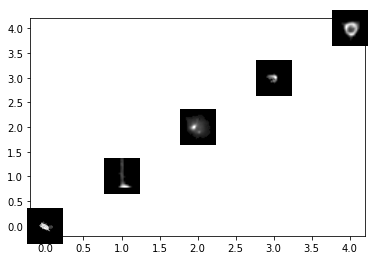

In [22]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.figure()

def getImage(img):
    return OffsetImage(img, cmap='gray')

x = [0,1,2,3,4]
y = [0,1,2,3,4]

fig, ax = plt.subplots()
ax.scatter(x, y) 

for x0, y0, path in zip(x, y, img_lst):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [23]:
# import matplotlib.pyplot as plt

# %matplotlib inline
# plt.figure()
# # plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, cmap=plt.get_cmap('tab10'))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, cmap=plt.get_cmap('tab10'))


In [24]:
import pandas as pd
xy_df = pd.DataFrame(features_embedded, columns=['x', 'y'])
xy_df['qc_x'] = pd.qcut(xy_df['x'], q=20)
xy_df['qc_y'] = pd.qcut(xy_df['y'], q=20)
xy_df['qc'] = xy_df['qc_x'].astype(str) + '_' + xy_df['qc_y'].astype(str)
smpl_imgs = xy_df.groupby('qc').sample(1)

In [25]:
xy_df['x_min'] = xy_df['x'].min()
xy_df['x_max'] = xy_df['x'].max()
xy_df['y_min'] = xy_df['y'].min()
xy_df['y_max'] = xy_df['y'].max()

xy_df['x_mm'] = (xy_df['x'] - xy_df['x_min']) / (xy_df['x_max'] - xy_df['x_min'])
xy_df['y_mm'] = (xy_df['y'] - xy_df['y_min']) / (xy_df['y_max'] - xy_df['y_min'])

xy_df['x_mmf'] = np.floor(xy_df['x_mm']*20)
xy_df['y_mmf'] = np.floor(xy_df['y_mm']*20)

xy_df['mmf'] = xy_df['x_mmf'].astype(str) + '_' + xy_df['y_mmf'].astype(str)
smpl_imgs = xy_df.groupby('mmf').sample(1)

<IPython.core.display.Javascript object>


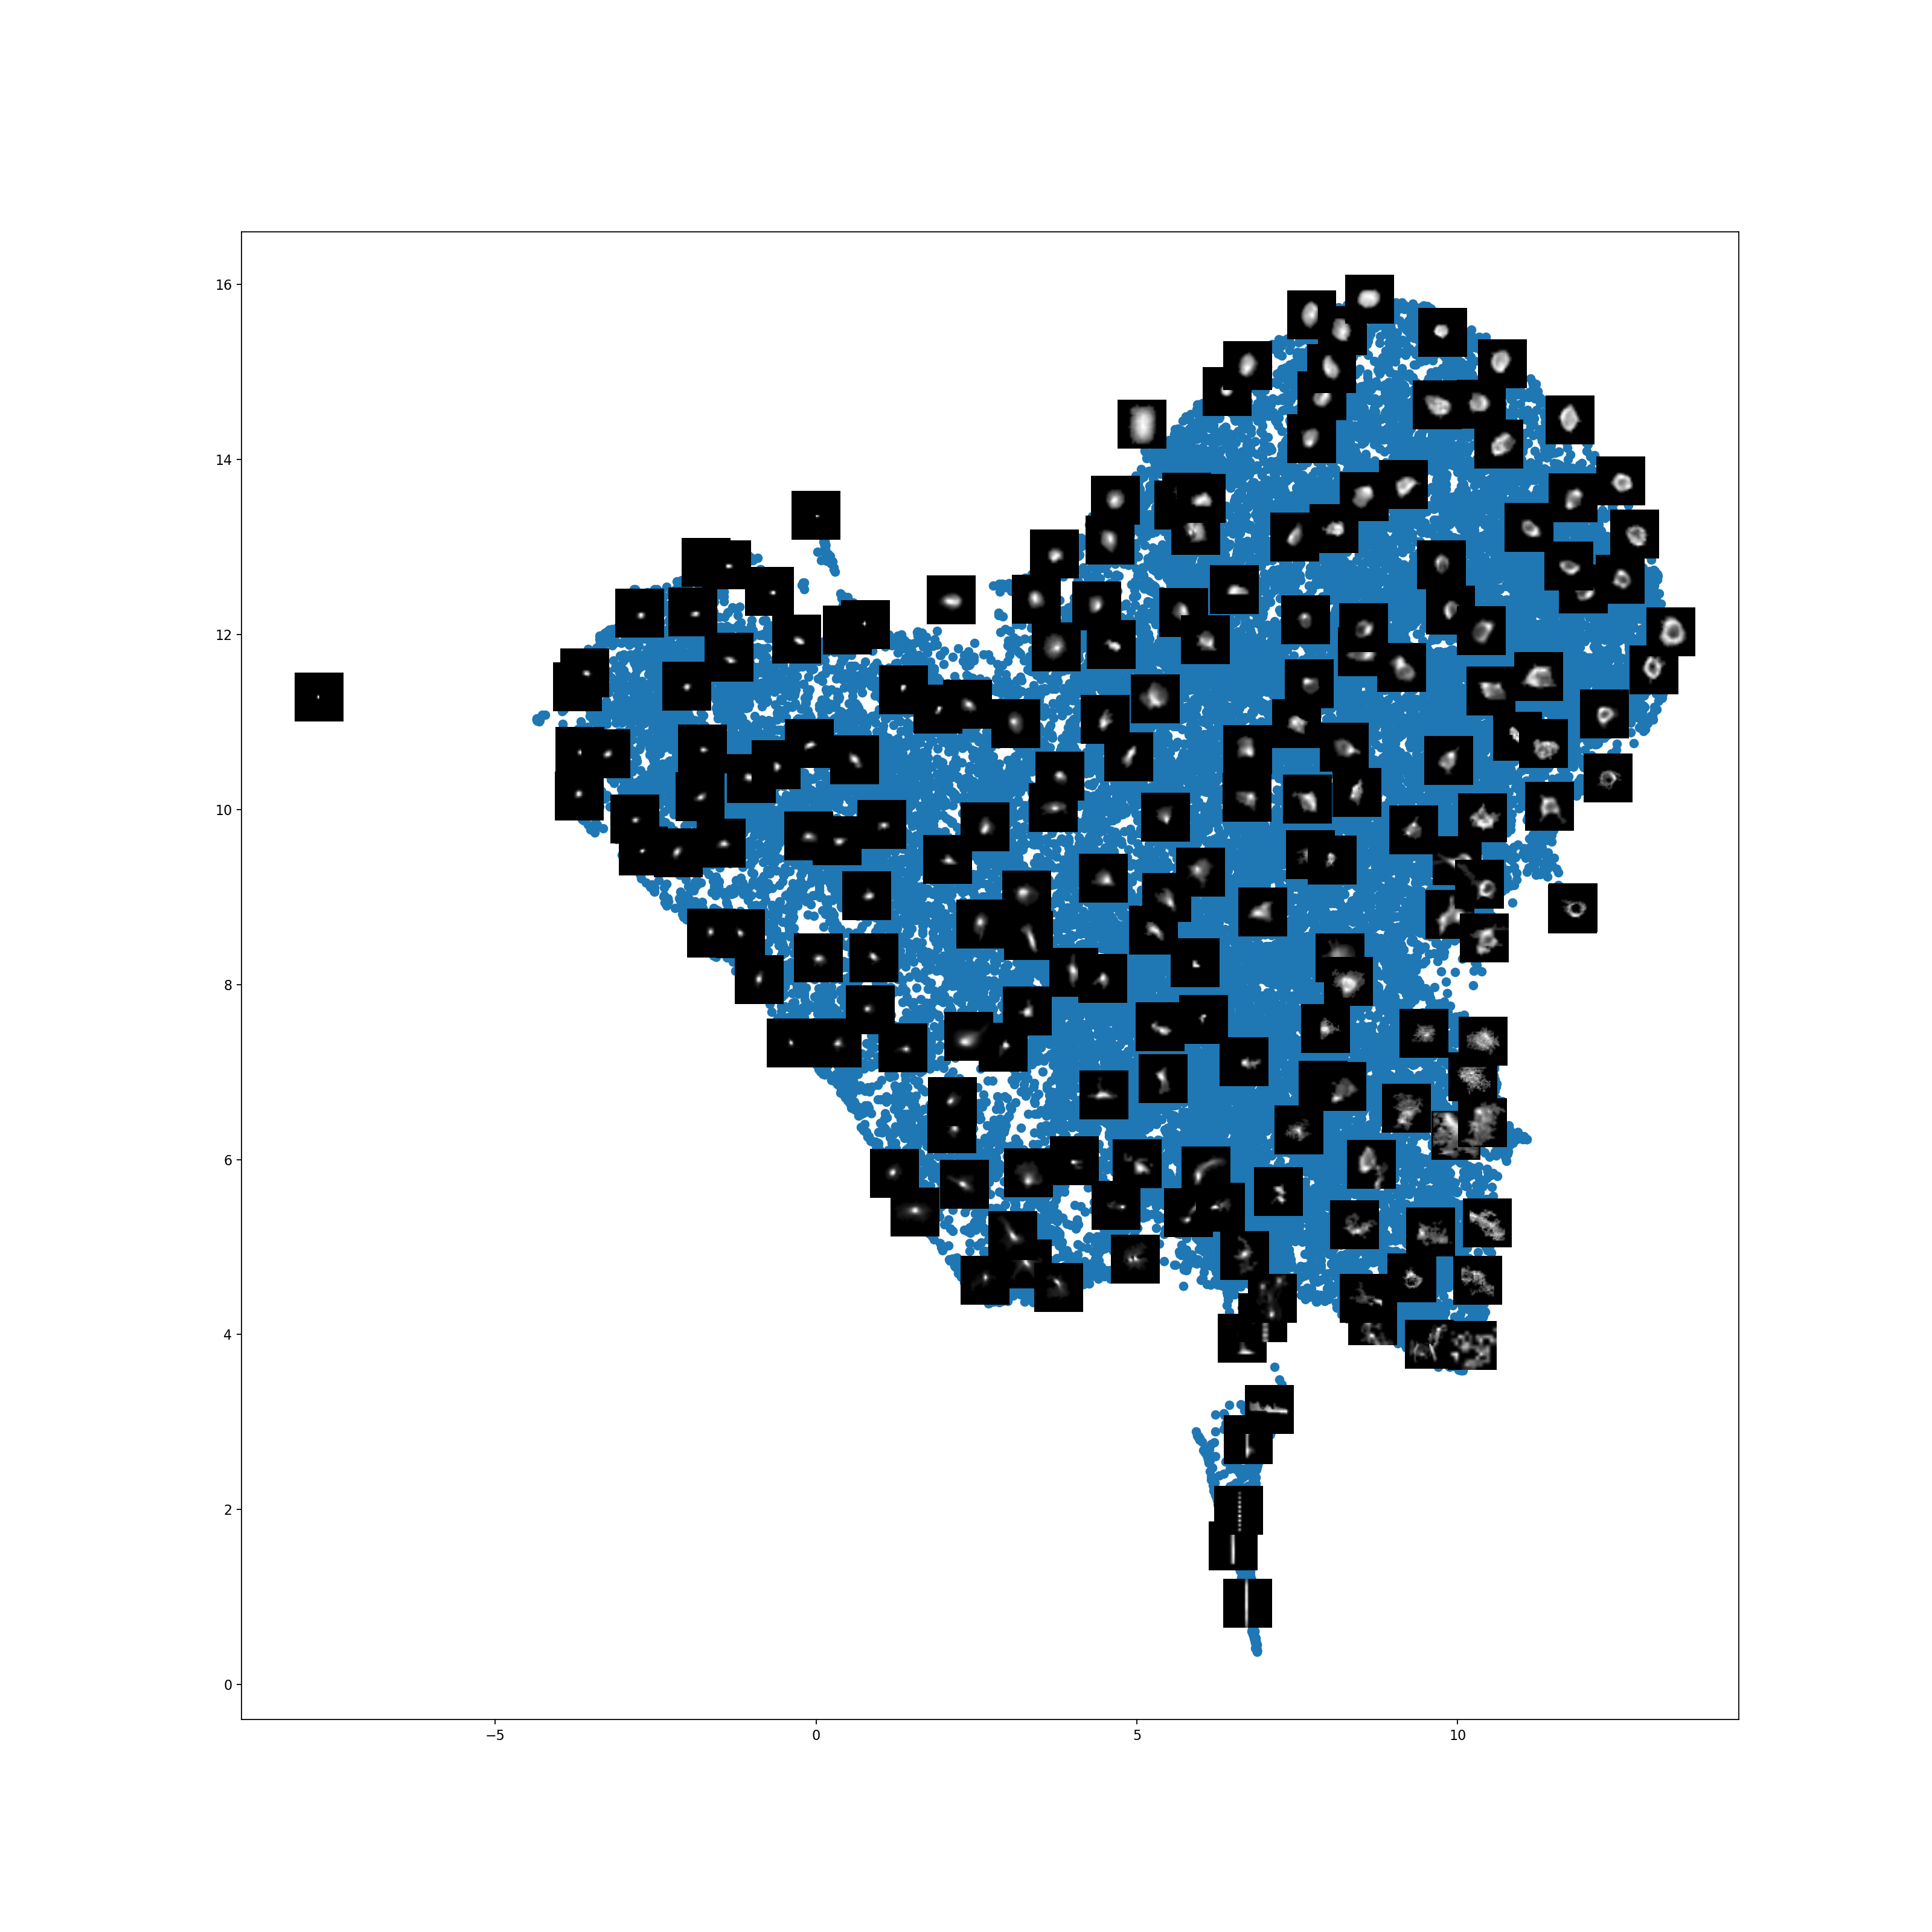

In [26]:
import matplotlib.pyplot as plt

%matplotlib notebook
# plt.figure()
fig, ax = plt.subplots(figsize=(20,20))
# plt.scatter(features_embedded[:,0], features_embedded[:,1], s=10, cmap=plt.get_cmap('tab10'))
# ax.scatter(features_embedded[:,0], features_embedded[:,1], cmap=plt.get_cmap('tab10'))
ax.scatter(features_embedded[:,0], features_embedded[:,1], cmap=plt.get_cmap('tab10'))

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# inx_lst = list(range(100))
inx_lst = list(smpl_imgs.index)
img_lst = full_data[inx_lst]
x = features_embedded[inx_lst, 0]
y = features_embedded[inx_lst, 1]

ax.scatter(x, y) 

for x0, y0, path in zip(x, y, img_lst):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

In [36]:
plt.savefig('tsne_viz_spatial_4.png')
plt.savefig('tsne_viz_spatial_4.svg')